In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import json
import matplotlib.pyplot as plt
from adjustText import adjust_text

from scipy.signal import spectrogram
import librosa

## SDR, SDRi, SI-SDR Metrics

In [6]:
# parse evaluation output file
def parse_output(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

        row_dict = {}
        for metric in lines[-2].split(','):
            split_line = metric.strip('\n').split(':')
            row_dict[split_line[0].strip()] = float(split_line[1].strip())

    return row_dict

gather = []
steps = [1] + [i for i in range(1, 200001) if i % 20000 == 0]

# Clap Baseline results
row_dict = parse_output(os.path.join('results/clap_baseline/audiosep_baseline'))
row_dict['Model'] = 'CLAP (Baseline)'

# duplicate baseline results for each time step for plotting purposes
for step in steps:
    print(step)
    row_dict['step'] = int(step)
    print(row_dict)
    gather.append(row_dict.copy())

# gather

1
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 1}
20000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 20000}
40000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 40000}
60000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 60000}
80000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 80000}
100000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 100000}
120000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 120000}
140000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 140000}
160000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 160000}
180000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 180000}
200000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.

In [7]:
# For each checkpoint, al_retrieval checkpoint run
results_dir = './results/onepeace_al_retrieval_checkpoint'
slurm_output_dir = os.path.join(results_dir, 'validation_outputs/slurm_files')

for step in steps:
    file_path = os.path.join(slurm_output_dir, f'step={step}.ckpt_log.txt')
    row_dict = parse_output(file_path)
    row_dict['step'] = int(step)
    row_dict['Model'] = 'ONE-PEACE al_checkpoint'

    gather.append(row_dict)


In [8]:
# For each checkpoint, baseline checkpoint run
results_dir = './results/onepeace_baseline_checkpoint'
slurm_output_dir = os.path.join(results_dir, 'validation_outputs/slurm_files')

for step in steps:
    file_path = os.path.join(slurm_output_dir, f'step={step}.ckpt_log.txt')
    row_dict = parse_output(file_path)
    row_dict['step'] = int(step)
    row_dict['Model'] = 'ONE-PEACE pretrained_checkpoint'

    gather.append(row_dict)

In [9]:
df = pd.DataFrame(gather)
df.to_csv(os.path.join(results_dir, 'validation_results.csv'), index=False)

In [10]:
df = pd.read_csv(os.path.join(results_dir, 'validation_results.csv'))

In [11]:
df.columns

Index(['SDR', 'SDRi', 'SISDR', 'Model', 'step'], dtype='object')

In [12]:
def line_plot(df, y, ax, x = 'step', hue = 'Model'):

    sns.lineplot(df, 
                 x=x, 
                 y = y,
                 hue = hue,  
                 marker='o',
                 ax = ax)

    texts = []
    # label points on the plot
    for x_val, y_val in zip(df[x], df[y]):
        texts.append(ax.text(x = x_val, 
                              y = y_val, 
                              s = f'{y_val:.2f}', 
                              color = 'blue'))
    
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5),
                ax = ax)
    

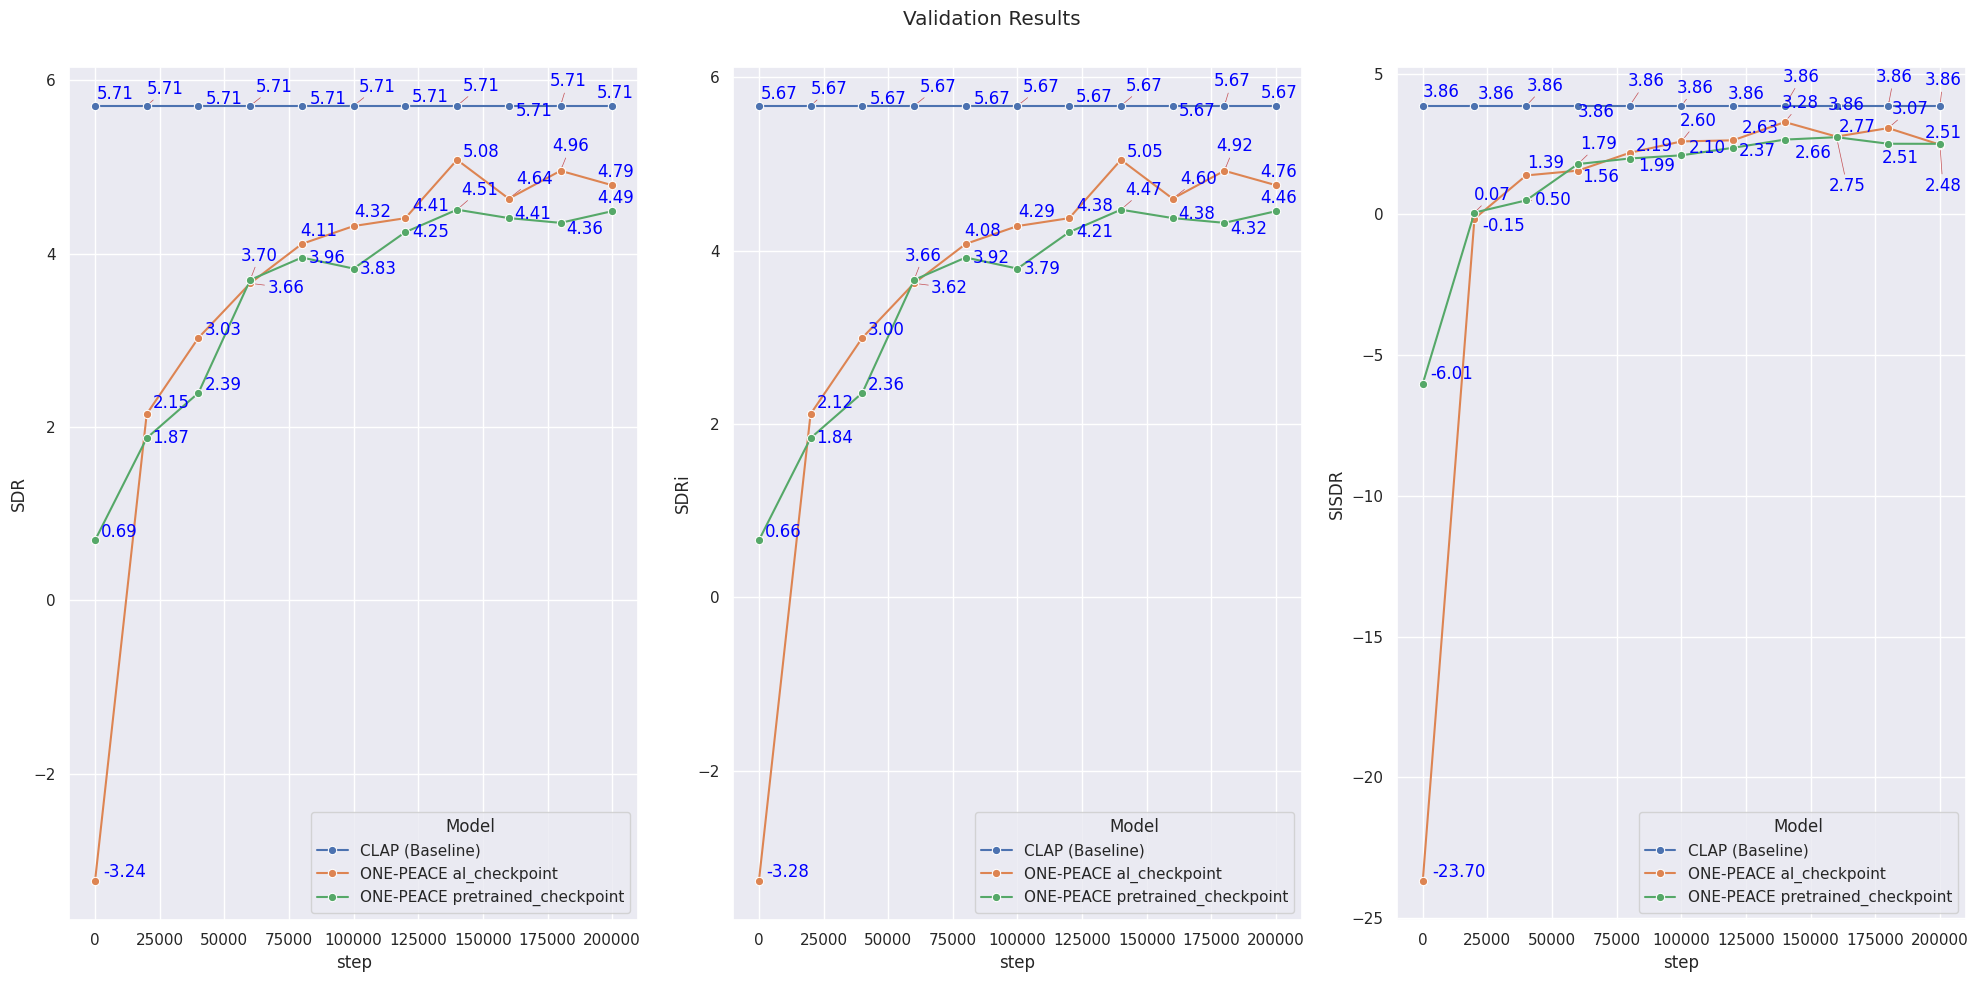

In [13]:
sns.set_theme()
fig, axes = plt.subplots(1,3, figsize = (20,10))

line_plot(df, 'SDR',   axes[0])
line_plot(df, 'SDRi',  axes[1])
line_plot(df, 'SISDR', axes[2])


plt.suptitle('Validation Results\n')
plt.tight_layout()

## Visualized Audio Spectrograms

In [14]:
sampling_rate = 16000
pd.set_option('display.max_colwidth', None)

In [15]:
# Generate and plot the spectrogram
def plot_spectrograms(mixture, source, sep_segment, sample_rate, name, output_dir, caption):

    os.makedirs(output_dir, exist_ok=True)
    FIG_SIZE = (6.4,4)
    DPI = 600


    # Load the audio file
    # sample_rate, data = load_wav(file_path)
    
    # Generate spectrogram for mixture audio
    frequencies, times, Sxx = spectrogram(mixture, fs=sample_rate)
    
    # Plot spectrogram
    plt.figure(figsize=FIG_SIZE, dpi=DPI)
    source_cmesh = plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma')
    
    # grabbing colorbar bounds but removing it lmao
    cbar = plt.colorbar(label='Power (dB)')
    vmax = source_cmesh.colorbar.norm.vmax
    vmin = source_cmesh.colorbar.norm.vmin
    cbar.remove()

    # plt.title('Mixture')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{name} mixture_spectrogram'))
    plt.close()
    # plt.show()


    # Generate spectrogram for separated segment output
    frequencies, times, Sxx = spectrogram(sep_segment, fs=sample_rate)
    
    # Plot spectrogram
    plt.figure(figsize=FIG_SIZE, dpi=DPI)
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma',
                   vmin=vmin, vmax=vmax)
    
    # plt.colorbar(label='Power (dB)')
    # plt.title('Separation Result')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{name} sep_spectrogram'))
    plt.close()
    # plt.show()


    # Generate spectrogram for source (target) audio
    frequencies, times, Sxx = spectrogram(source, fs=sample_rate)
    
    # sometimes there are time steps where this no sound for some timesteps in the target audio
    # this leads to a nan power value so fill with vmin
    power = 10 * np.log10(Sxx)
    power = np.nan_to_num(power, nan = vmin)
    # Plot spectrogram
    plt.figure(figsize=FIG_SIZE, dpi = DPI)
    plt.pcolormesh(times, frequencies, power, shading='gouraud', cmap = 'plasma',
                   vmin=vmin, vmax=vmax)
    
    # plt.colorbar(label='Power (dB)')
    # plt.title('Target')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir,f'{name} target_spectrogram'))
    plt.close()
    # plt.show()


    with open(os.path.join(output_dir, 'caption.txt'), 'w') as f:
        f.write(caption)
        f.close()

def make_spectrograms_for_sample(clap_sample, onepeace_sample, output_dir):
    source_path = clap_sample.source_path
    mixture_path = clap_sample.input_path
    sep_path = clap_sample.output_path
    caption = clap_sample.caption
    mixture, fs = librosa.load(mixture_path, sr=sampling_rate, mono=True)
    source, fs = librosa.load(source_path, sr=sampling_rate, mono=True)
    sep_segment, fs = librosa.load(sep_path, sr=sampling_rate, mono=True)

    plot_spectrograms(mixture, source, sep_segment, sampling_rate, 'clap', output_dir, caption)

    source_path = onepeace_sample.source_path
    mixture_path = onepeace_sample.input_path
    sep_path = onepeace_sample.output_path
    caption = onepeace_sample.caption
    mixture, fs = librosa.load(mixture_path, sr=sampling_rate, mono=True)
    source, fs = librosa.load(source_path, sr=sampling_rate, mono=True)
    sep_segment, fs = librosa.load(sep_path, sr=sampling_rate, mono=True)
    plot_spectrograms(mixture, source, sep_segment, sampling_rate, 'onepeace', output_dir, caption)

    


In [16]:
df_onepeace = pd.read_csv('results/one-peace_validation_results.csv')
df_onepeace[:3]

,caption,source_path,noise_path,input_path,output_path,input_similarity,output_similarity,target_similarity,sisdr,sdri,sdr,delta_similarity
0,"Someone is playing a kind of musical instrument, which makes a buzzing sound.",lass_validation/692211_12333864-hq.wav,lass_validation/701692_6014995-hq.wav,"/fs/nexus-scratch/vla/lass_validation_onepeace_output/('692211_12333864-hq.wav', '701692_6014995-hq.wav')_input.wav","/fs/nexus-scratch/vla/lass_validation_onepeace_output/('692211_12333864-hq.wav', '701692_6014995-hq.wav')_output.wav",0.401701,0.403737,0.470765,9.953128,0.024985,10.024985,0.002035
1,"Someone is playing the musical instrument, which produces buzzing sounds.",lass_validation/692211_12333864-hq.wav,lass_validation/708399_14710576-hq.wav,"/fs/nexus-scratch/vla/lass_validation_onepeace_output/('692211_12333864-hq.wav', '708399_14710576-hq.wav')_input.wav","/fs/nexus-scratch/vla/lass_validation_onepeace_output/('692211_12333864-hq.wav', '708399_14710576-hq.wav')_output.wav",0.306772,0.284680,0.452296,9.277602,8.761090,9.761090,-0.022092
2,The musical instrument is producing buzzing sounds.,lass_validation/692211_12333864-hq.wav,lass_validation/708360_14781196-hq.wav,"/fs/nexus-scratch/vla/lass_validation_onepeace_output/('692211_12333864-hq.wav', '708360_14781196-hq.wav')_input.wav","/fs/nexus-scratch/vla/lass_validation_onepeace_output/('692211_12333864-hq.wav', '708360_14781196-hq.wav')_output.wav",0.293939,0.356307,0.487627,1.753260,16.971467,3.971467,0.062368


In [17]:
df_clap = pd.read_csv('results/baseline_validation_results.csv')
df_clap[:3]

,caption,source_path,noise_path,input_path,output_path,input_similarity,output_similarity,target_similarity,sisdr,sdri,sdr,delta_similarity
0,"Someone is playing a kind of musical instrument, which makes a buzzing sound.",lass_validation/692211_12333864-hq.wav,lass_validation/701692_6014995-hq.wav,"/fs/nexus-scratch/vla/lass_validation_baseline_output/('692211_12333864-hq.wav', '701692_6014995-hq.wav')_input.wav","/fs/nexus-scratch/vla/lass_validation_baseline_output/('692211_12333864-hq.wav', '701692_6014995-hq.wav')_output.wav",0.081376,0.085678,0.099061,9.980114,0.076613,10.076612,0.004302
1,"Someone is playing the musical instrument, which produces buzzing sounds.",lass_validation/692211_12333864-hq.wav,lass_validation/708399_14710576-hq.wav,"/fs/nexus-scratch/vla/lass_validation_baseline_output/('692211_12333864-hq.wav', '708399_14710576-hq.wav')_input.wav","/fs/nexus-scratch/vla/lass_validation_baseline_output/('692211_12333864-hq.wav', '708399_14710576-hq.wav')_output.wav",0.201099,0.182382,0.136972,9.162392,8.639180,9.639180,-0.018717
2,The musical instrument is producing buzzing sounds.,lass_validation/692211_12333864-hq.wav,lass_validation/708360_14781196-hq.wav,"/fs/nexus-scratch/vla/lass_validation_baseline_output/('692211_12333864-hq.wav', '708360_14781196-hq.wav')_input.wav","/fs/nexus-scratch/vla/lass_validation_baseline_output/('692211_12333864-hq.wav', '708360_14781196-hq.wav')_output.wav",0.238575,0.220378,0.192079,1.553409,16.836760,3.836760,-0.018197


## Best SDR

In [18]:
# best onepeace sdr sample
best_sdr = df_onepeace.sort_values(by = 'sdr', ascending=False).iloc[0]
best_sdr

caption                                                                         The heart is beating forcefully, making a thumping sound.
source_path                                                                                        lass_validation/688735_10403690-hq.wav
noise_path                                                                                          lass_validation/687039_2448533-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_onepeace_output/('688735_10403690-hq.wav', '687039_2448533-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_onepeace_output/('688735_10403690-hq.wav', '687039_2448533-hq.wav')_output.wav
input_similarity                                                                                                                 0.294499
output_similarity                                                                                                                0.523779
target_similarity                 

In [19]:
clap_equiv = df_clap.loc[2717]
clap_equiv

caption                                                                         The heart is beating forcefully, making a thumping sound.
source_path                                                                                        lass_validation/688735_10403690-hq.wav
noise_path                                                                                          lass_validation/687039_2448533-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_baseline_output/('688735_10403690-hq.wav', '687039_2448533-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_baseline_output/('688735_10403690-hq.wav', '687039_2448533-hq.wav')_output.wav
input_similarity                                                                                                                 0.239523
output_similarity                                                                                                                0.483984
target_similarity                 

In [20]:
output_dir = 'plots/onepeace_best_sdr'
make_spectrograms_for_sample(clap_equiv, best_sdr, output_dir)

/tmp/ipykernel_2405437/211326714.py:17: RuntimeWarning: divide by zero encountered in log10
  source_cmesh = plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma')
/tmp/ipykernel_2405437/211326714.py:58: RuntimeWarning: divide by zero encountered in log10
  power = 10 * np.log10(Sxx)
/fs/nexus-scratch/vla/micromamba/envs/LASS/lib/python3.9/site-packages/matplotlib/colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


In [21]:
# best clap sdr example
best_sdr = df_clap.sort_values(by = 'sdr', ascending=False).iloc[0]
best_sdr

caption                                                                                              Someone's heart is beating violently.
source_path                                                                                         lass_validation/688735_10403690-hq.wav
noise_path                                                                                          lass_validation/701640_10586310-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_baseline_output/('688735_10403690-hq.wav', '701640_10586310-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_baseline_output/('688735_10403690-hq.wav', '701640_10586310-hq.wav')_output.wav
input_similarity                                                                                                                  0.257285
output_similarity                                                                                                                 0.483456
target_similarity          

In [22]:
onepeace_equiv = df_onepeace.loc[2715]
onepeace_equiv

caption                                                                                              Someone's heart is beating violently.
source_path                                                                                         lass_validation/688735_10403690-hq.wav
noise_path                                                                                          lass_validation/701640_10586310-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_onepeace_output/('688735_10403690-hq.wav', '701640_10586310-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_onepeace_output/('688735_10403690-hq.wav', '701640_10586310-hq.wav')_output.wav
input_similarity                                                                                                                  0.335711
output_similarity                                                                                                                  0.38555
target_similarity          

In [23]:
output_dir = 'plots/clap_best_sdr'
make_spectrograms_for_sample(best_sdr, onepeace_equiv, output_dir)

/tmp/ipykernel_2405437/211326714.py:58: RuntimeWarning: divide by zero encountered in log10
  power = 10 * np.log10(Sxx)


## Best SDRi

In [24]:
# best onepeace sdri example
best_sdri = df_onepeace.sort_values(by = 'sdri', ascending=False).iloc[0]
best_sdri

caption                                                                          Someone is shoveling something, making a clinking sound.
source_path                                                                                        lass_validation/700237_10996917-hq.wav
noise_path                                                                                          lass_validation/704937_5828667-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_onepeace_output/('700237_10996917-hq.wav', '704937_5828667-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_onepeace_output/('700237_10996917-hq.wav', '704937_5828667-hq.wav')_output.wav
input_similarity                                                                                                                 0.334947
output_similarity                                                                                                                 0.40852
target_similarity                 

In [25]:
clap_equiv = df_clap.loc[763]
clap_equiv

caption                                                                          Someone is shoveling something, making a clinking sound.
source_path                                                                                        lass_validation/700237_10996917-hq.wav
noise_path                                                                                          lass_validation/704937_5828667-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_baseline_output/('700237_10996917-hq.wav', '704937_5828667-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_baseline_output/('700237_10996917-hq.wav', '704937_5828667-hq.wav')_output.wav
input_similarity                                                                                                                 0.308157
output_similarity                                                                                                                0.307138
target_similarity                 

In [26]:
output_dir = 'plots/onepeace_best_sdri'
make_spectrograms_for_sample(clap_equiv, best_sdri, output_dir)

/tmp/ipykernel_2405437/211326714.py:58: RuntimeWarning: divide by zero encountered in log10
  power = 10 * np.log10(Sxx)


In [27]:
# best clap sdri example
best_sdri = df_clap.sort_values(by = 'sdri', ascending=False).iloc[0]
best_sdri

caption                                                                First, there is an explosion echo, then suddenly comes a big boom.
source_path                                                                                         lass_validation/702285_5828667-hq.wav
noise_path                                                                                         lass_validation/682322_10938187-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_baseline_output/('702285_5828667-hq.wav', '682322_10938187-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_baseline_output/('702285_5828667-hq.wav', '682322_10938187-hq.wav')_output.wav
input_similarity                                                                                                                 0.145986
output_similarity                                                                                                                0.369625
target_similarity                 

In [28]:
onepeace_equiv = df_onepeace.loc[1995]
onepeace_equiv

caption                                                                First, there is an explosion echo, then suddenly comes a big boom.
source_path                                                                                         lass_validation/702285_5828667-hq.wav
noise_path                                                                                         lass_validation/682322_10938187-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_onepeace_output/('702285_5828667-hq.wav', '682322_10938187-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_onepeace_output/('702285_5828667-hq.wav', '682322_10938187-hq.wav')_output.wav
input_similarity                                                                                                                  0.21198
output_similarity                                                                                                                0.417818
target_similarity                 

In [29]:
output_dir = 'plots/clap_best_sdri'
make_spectrograms_for_sample(best_sdri, onepeace_equiv, output_dir)

/tmp/ipykernel_2405437/211326714.py:58: RuntimeWarning: divide by zero encountered in log10
  power = 10 * np.log10(Sxx)


## Best delta_similarity

In [30]:
best_delta_similarity = df_onepeace.sort_values(by = 'delta_similarity', ascending=False).iloc[0]
best_delta_similarity

caption                                                      Fireworks are shot into the air with swirling sounds and then they explode.
source_path                                                                                        lass_validation/694373_2578040-hq.wav
noise_path                                                                                         lass_validation/707282_1661766-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_onepeace_output/('694373_2578040-hq.wav', '707282_1661766-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_onepeace_output/('694373_2578040-hq.wav', '707282_1661766-hq.wav')_output.wav
input_similarity                                                                                                               -0.098684
output_similarity                                                                                                               0.457966
target_similarity                        

In [31]:
clap_equiv = df_clap.loc[986]
clap_equiv

caption                                                      Fireworks are shot into the air with swirling sounds and then they explode.
source_path                                                                                        lass_validation/694373_2578040-hq.wav
noise_path                                                                                         lass_validation/707282_1661766-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_baseline_output/('694373_2578040-hq.wav', '707282_1661766-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_baseline_output/('694373_2578040-hq.wav', '707282_1661766-hq.wav')_output.wav
input_similarity                                                                                                                0.246288
output_similarity                                                                                                               0.369976
target_similarity                        

In [32]:
output_dir = 'plots/onepeace_best_delta_similarity'
make_spectrograms_for_sample(clap_equiv, best_delta_similarity, output_dir)

In [33]:
best_delta_similarity = df_clap.sort_values(by = 'delta_similarity', ascending=False).iloc[0]
best_delta_similarity

caption                                                                                     There is a sound of explosion in the distance.
source_path                                                                                         lass_validation/699245_15101941-hq.wav
noise_path                                                                                          lass_validation/686774_11771918-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_baseline_output/('699245_15101941-hq.wav', '686774_11771918-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_baseline_output/('699245_15101941-hq.wav', '686774_11771918-hq.wav')_output.wav
input_similarity                                                                                                                 -0.077745
output_similarity                                                                                                                 0.331277
target_similarity          

In [34]:
onepeace_equiv = df_onepeace.loc[621]
onepeace_equiv

caption                                                                                     There is a sound of explosion in the distance.
source_path                                                                                         lass_validation/699245_15101941-hq.wav
noise_path                                                                                          lass_validation/686774_11771918-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_onepeace_output/('699245_15101941-hq.wav', '686774_11771918-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_onepeace_output/('699245_15101941-hq.wav', '686774_11771918-hq.wav')_output.wav
input_similarity                                                                                                                  0.236577
output_similarity                                                                                                                 0.512512
target_similarity          

In [35]:
output_dir = 'plots/clap_best_delta_similarity'
make_spectrograms_for_sample(best_delta_similarity, onepeace_equiv, output_dir)

## Best SISDR

In [36]:
# NOTE: best SDR and SISDR score for ONE-PEACE is the same

In [37]:
# NOTE: best SISDR and SDR score for CLAP is the same too
best_sisdr = df_clap.sort_values(by = 'sisdr', ascending=False).iloc[0]
best_sisdr

caption                                                                                              Someone's heart is beating violently.
source_path                                                                                         lass_validation/688735_10403690-hq.wav
noise_path                                                                                          lass_validation/701640_10586310-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_baseline_output/('688735_10403690-hq.wav', '701640_10586310-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_baseline_output/('688735_10403690-hq.wav', '701640_10586310-hq.wav')_output.wav
input_similarity                                                                                                                  0.257285
output_similarity                                                                                                                 0.483456
target_similarity          

## Looking for differences in performance

In [38]:
df_all = df_onepeace.join(df_clap, lsuffix= '_onepeace', rsuffix='_clap')
df_all[:5]

,caption_onepeace,source_path_onepeace,noise_path_onepeace,input_path_onepeace,output_path_onepeace,input_similarity_onepeace,output_similarity_onepeace,target_similarity_onepeace,sisdr_onepeace,sdri_onepeace,...,noise_path_clap,input_path_clap,output_path_clap,input_similarity_clap,output_similarity_clap,target_similarity_clap,sisdr_clap,sdri_clap,sdr_clap,delta_similarity_clap
0,"Someone is playing a kind of musical instrument, which makes a buzzing sound.",lass_validation/692211_12333864-hq.wav,lass_validation/701692_6014995-hq.wav,"/fs/nexus-scratch/vla/lass_validation_onepeace_output/('692211_12333864-hq.wav', '701692_6014995-hq.wav')_input.wav","/fs/nexus-scratch/vla/lass_validation_onepeace_output/('692211_12333864-hq.wav', '701692_6014995-hq.wav')_output.wav",0.401701,0.403737,0.470765,9.953128,0.024985,...,lass_validation/701692_6014995-hq.wav,"/fs/nexus-scratch/vla/lass_validation_baseline_output/('692211_12333864-hq.wav', '701692_6014995-hq.wav')_input.wav","/fs/nexus-scratch/vla/lass_validation_baseline_output/('692211_12333864-hq.wav', '701692_6014995-hq.wav')_output.wav",0.081376,0.085678,0.099061,9.980114,0.076613,10.076612,0.004302
1,"Someone is playing the musical instrument, which produces buzzing sounds.",lass_validation/692211_12333864-hq.wav,lass_validation/708399_14710576-hq.wav,"/fs/nexus-scratch/vla/lass_validation_onepeace_output/('692211_12333864-hq.wav', '708399_14710576-hq.wav')_input.wav","/fs/nexus-scratch/vla/lass_validation_onepeace_output/('692211_12333864-hq.wav', '708399_14710576-hq.wav')_output.wav",0.306772,0.284680,0.452296,9.277602,8.761090,...,lass_validation/708399_14710576-hq.wav,"/fs/nexus-scratch/vla/lass_validation_baseline_output/('692211_12333864-hq.wav', '708399_14710576-hq.wav')_input.wav","/fs/nexus-scratch/vla/lass_validation_baseline_output/('692211_12333864-hq.wav', '708399_14710576-hq.wav')_output.wav",0.201099,0.182382,0.136972,9.162392,8.639180,9.639180,-0.018717
2,The musical instrument is producing buzzing sounds.,lass_validation/692211_12333864-hq.wav,lass_validation/708360_14781196-hq.wav,"/fs/nexus-scratch/vla/lass_validation_onepeace_output/('692211_12333864-hq.wav', '708360_14781196-hq.wav')_input.wav","/fs/nexus-scratch/vla/lass_validation_onepeace_output/('692211_12333864-hq.wav', '708360_14781196-hq.wav')_output.wav",0.293939,0.356307,0.487627,1.753260,16.971467,...,lass_validation/708360_14781196-hq.wav,"/fs/nexus-scratch/vla/lass_validation_baseline_output/('692211_12333864-hq.wav', '708360_14781196-hq.wav')_input.wav","/fs/nexus-scratch/vla/lass_validation_baseline_output/('692211_12333864-hq.wav', '708360_14781196-hq.wav')_output.wav",0.238575,0.220378,0.192079,1.553409,16.836760,3.836760,-0.018197
3,There are some motorcycles and cars on the road starting their engines and speeding past.,lass_validation/699830_15175263-hq.wav,lass_validation/692865_2250422-hq.wav,"/fs/nexus-scratch/vla/lass_validation_onepeace_output/('699830_15175263-hq.wav', '692865_2250422-hq.wav')_input.wav","/fs/nexus-scratch/vla/lass_validation_onepeace_output/('699830_15175263-hq.wav', '692865_2250422-hq.wav')_output.wav",0.060706,0.220841,0.240632,5.140363,12.075294,...,lass_validation/692865_2250422-hq.wav,"/fs/nexus-scratch/vla/lass_validation_baseline_output/('699830_15175263-hq.wav', '692865_2250422-hq.wav')_input.wav","/fs/nexus-scratch/vla/lass_validation_baseline_output/('699830_15175263-hq.wav', '692865_2250422-hq.wav')_output.wav",0.271937,0.245885,0.266185,4.121937,11.542630,5.542631,-0.026052
4,A race car engine roars as it accelerates and passes on the track.,lass_validation/699830_15175263-hq.wav,lass_validation/695808_5812781-hq.wav,"/fs/nexus-scratch/vla/lass_validation_onepeace_output/('699830_15175263-hq.wav', '695808_5812781-hq.wav')_input.wav","/fs/nexus-scratch/vla/lass_validation_onepeace_output/('699830_15175263-hq.wav', '695808_5812781-hq.wav')_output.wav",0.355908,0.388010,0.422350,10.268353,0.391239,...,lass_validation/695808_5812781-hq.wav,"/fs/nexus-scratc

In [39]:
df_all.sort_values(by = 'sdr_onepeace')[['sdr_onepeace', 'sdr_clap']][:20]

,sdr_onepeace,sdr_clap
2780,-14.956078,-9.921728
2120,-14.939930,-14.931655
2296,-14.842997,-14.399668
1923,-14.527849,-7.170307
795,-14.079497,-13.644784
585,-14.018537,2.865011
1144,-14.015432,-13.988082
1935,-13.960302,-5.419256
974,-13.950046,-12.911837
583,-13.877188,-13.511446


In [40]:
# Lets look at index == 585

In [41]:
clap_sample = df_clap.loc[585]
clap_sample

caption                                                                             A scary music is coming from the speech synthesizer.
source_path                                                                                       lass_validation/696701_12458758-hq.wav
noise_path                                                                                          lass_validation/711215_589889-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_baseline_output/('696701_12458758-hq.wav', '711215_589889-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_baseline_output/('696701_12458758-hq.wav', '711215_589889-hq.wav')_output.wav
input_similarity                                                                                                                0.145807
output_similarity                                                                                                               0.266206
target_similarity                        

In [42]:
onepeace_sample = df_onepeace.loc[585]
onepeace_sample

caption                                                                             A scary music is coming from the speech synthesizer.
source_path                                                                                       lass_validation/696701_12458758-hq.wav
noise_path                                                                                          lass_validation/711215_589889-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_onepeace_output/('696701_12458758-hq.wav', '711215_589889-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_onepeace_output/('696701_12458758-hq.wav', '711215_589889-hq.wav')_output.wav
input_similarity                                                                                                                0.113926
output_similarity                                                                                                               0.147124
target_similarity                        

In [43]:
output_dir = 'plots/speech_synth'
make_spectrograms_for_sample(clap_sample, onepeace_sample, output_dir)

In [44]:
df_all.sort_values(by = 'sdr_clap', ascending=False)[['sdr_onepeace', 'sdr_clap']][:20]

,sdr_onepeace,sdr_clap
2715,23.707760,40.512689
2717,34.872441,36.795452
762,30.361415,33.221822
1447,26.033084,29.110645
1684,29.194786,28.924105
285,2.020119,28.562864
1095,11.402878,28.207850
523,31.687647,28.187472
72,28.881415,28.006727
2161,26.613791,27.781611


In [45]:
# lets look at index == 285

In [46]:
clap_sample = df_clap.loc[285]
clap_sample

caption                                                  The sword swooshes through the air as someone waves it, making a whooshing sound.
source_path                                                                                         lass_validation/699930_10996917-hq.wav
noise_path                                                                                          lass_validation/683018_10624050-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_baseline_output/('699930_10996917-hq.wav', '683018_10624050-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_baseline_output/('699930_10996917-hq.wav', '683018_10624050-hq.wav')_output.wav
input_similarity                                                                                                                  0.390963
output_similarity                                                                                                                 0.560391
target_similarity          

In [47]:
onepeace_sample = df_onepeace.loc[285]
onepeace_sample

caption                                                  The sword swooshes through the air as someone waves it, making a whooshing sound.
source_path                                                                                         lass_validation/699930_10996917-hq.wav
noise_path                                                                                          lass_validation/683018_10624050-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_onepeace_output/('699930_10996917-hq.wav', '683018_10624050-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_onepeace_output/('699930_10996917-hq.wav', '683018_10624050-hq.wav')_output.wav
input_similarity                                                                                                                  0.163938
output_similarity                                                                                                                 0.315517
target_similarity          

In [48]:
output_dir = 'plots/sword_swoosh'
make_spectrograms_for_sample(clap_sample, onepeace_sample, output_dir)

/tmp/ipykernel_2405437/211326714.py:58: RuntimeWarning: divide by zero encountered in log10
  power = 10 * np.log10(Sxx)
/fs/nexus-scratch/vla/micromamba/envs/LASS/lib/python3.9/site-packages/matplotlib/colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/tmp/ipykernel_2405437/211326714.py:40: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma',
